In [1]:
import os
import platform

OS_PREFIX = "D:/data/" if platform.system() == "Windows" else ""
DATA_PATH = OS_PREFIX + "kaggle/input/lgg-mri-segmentation/kaggle_3m/"


In [2]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

plt.style.use("dark_background")


In [3]:
# Constants
BASE_LEN = 89
END_IMG_LEN = 4
END_MASK_LEN = 9
IMG_SIZE = 512


In [4]:
# Data mapping
data_map = []
for sub_dir_path in glob.glob(DATA_PATH + "*"):
    if os.path.isdir(sub_dir_path):
        dirname = os.path.basename(sub_dir_path)
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            data_map.extend([dirname, image_path])
df = pd.DataFrame({ 'dirname': data_map[::2], 'path': data_map[1::2] })
df.head()


,dirname,path
0,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
1,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
2,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
3,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
4,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...


In [5]:
# Image/mask sorting
df_imgs  = df[~df['path'].str.contains("mask")].copy()
df_masks = df[df['path'].str.contains("mask")].copy()
import re

def extract_slice_number(path: str) -> int:
    m = re.search(r'_(\d+)(?:_mask)?\.tif$', path)
    if not m:
        raise ValueError(f"Could not parse slice number from {path!r}")
    return int(m.group(1))


imgs  = sorted(df_imgs['path'].tolist(),  key=extract_slice_number)
masks = sorted(df_masks['path'].tolist(), key=extract_slice_number)


df = pd.DataFrame({
    'patient':    df_imgs['dirname'].values,
    'image_path': imgs,
    'mask_path':  masks
})

df.head()

,patient,image_path,mask_path
0,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
1,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
2,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
3,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...
4,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...


In [6]:
# Diagnosis column
def positiv_negativ_diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0
df['diagnosis'] = df['mask_path'].apply(positiv_negativ_diagnosis)
df.head()


,patient,image_path,mask_path,diagnosis
0,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,0
1,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,0
2,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,0
3,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,0
4,TCGA_HT_7686_19950629,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,kaggle/input/lgg-mri-segmentation/kaggle_3m/TC...,0


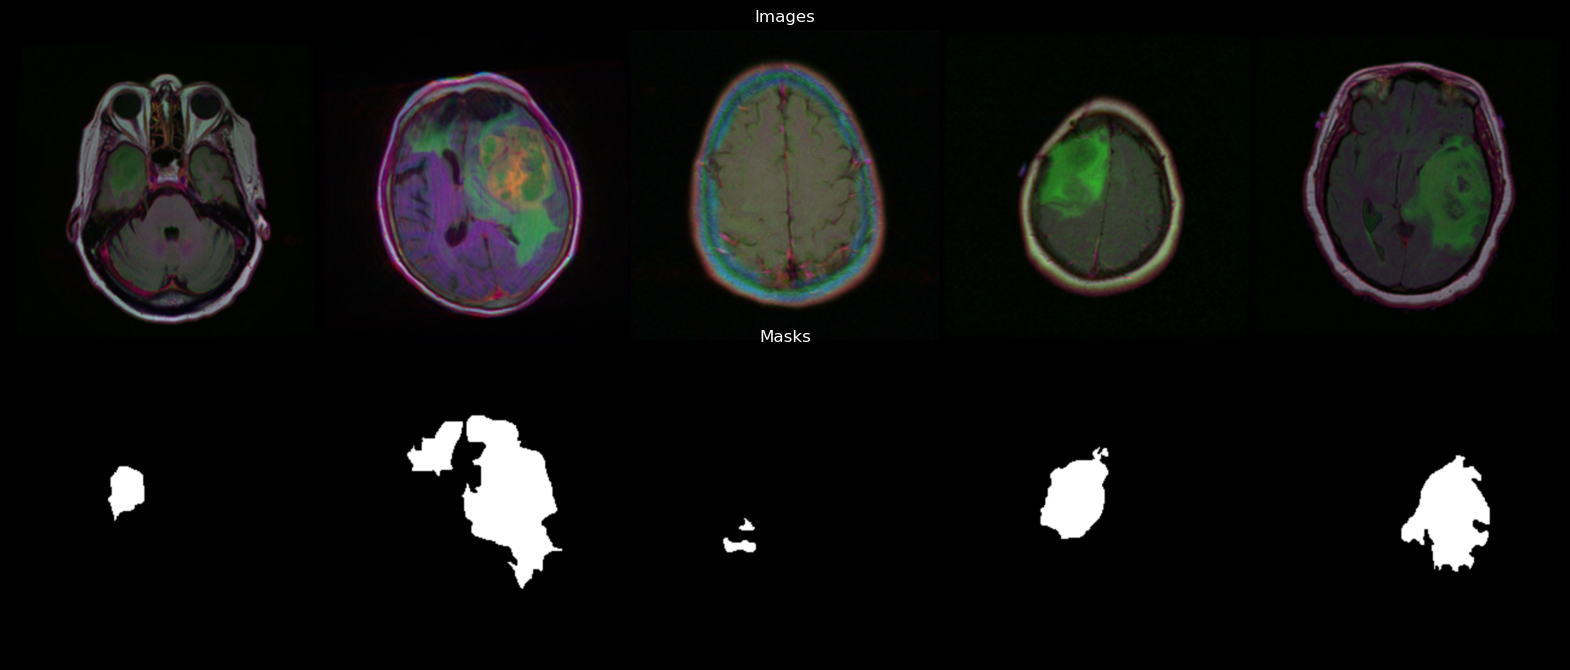

In [7]:
# Sample visualization
sample_df = df[df['diagnosis']==1].sample(5).values
imgs, masks = [], []
for _, img_path, mask_path, _ in sample_df:
    imgs.append(cv2.resize(cv2.imread(img_path), (IMG_SIZE, IMG_SIZE)))
    masks.append(cv2.resize(cv2.imread(mask_path), (IMG_SIZE, IMG_SIZE)))
fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.1)
grid[0].imshow(np.hstack(imgs));  grid[0].set_title('Images'); grid[0].axis('off')
grid[1].imshow(np.hstack(masks)); grid[1].set_title('Masks');  grid[1].axis('off')
plt.show()


In [8]:
# Quick summary metrics
total_samples = len(df)
unique_patients = df['patient'].nunique()
imgs_per_patient = df.groupby('patient').size()
counts = df['diagnosis'].value_counts()
pct_empty = counts.get(0,0)/total_samples*100
pct_pos = counts.get(1,0)/total_samples*100
print(f"Total samples: {total_samples}")
print(f"Unique patients: {unique_patients}")
print(f"Empty masks: {counts.get(0,0)} ({pct_empty:.1f}%)")
print(f"Tumor masks: {counts.get(1,0)} ({pct_pos:.1f}%)")


Total samples: 3929
Unique patients: 110
Empty masks: 2556 (65.1%)
Tumor masks: 1373 (34.9%)


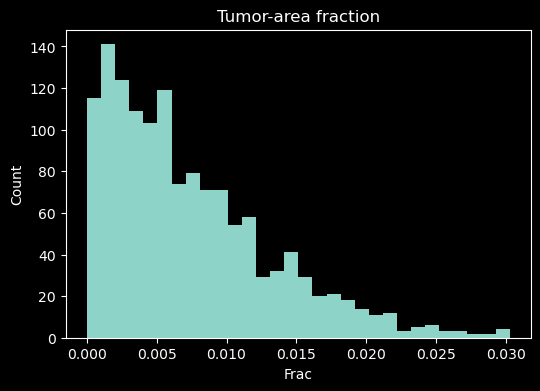

In [9]:
# Mask-area distribution
df['mask_frac'] = df['mask_path'].apply(lambda p: (cv2.imread(p,0)>0).sum()/IMG_SIZE**2)
cover = df.loc[df['diagnosis']==1, 'mask_frac']
plt.figure(figsize=(6,4)); plt.hist(cover, bins=30)
plt.title('Tumor-area fraction'); plt.xlabel('Frac'); plt.ylabel('Count'); plt.show()


In [10]:
# Pixel-intensity stats
# besagt wie hell/dunkel die Bilder im Schnitt sind
# (μ) und wie stark die Helligkeitswerte innerhalb der Bilder streuen (σ).
stats = df.sample(200)['image_path'].apply(lambda p: cv2.imread(p,0).astype(float)).apply(lambda im: (im.mean(), im.std()))
means, stds = zip(*stats)
print(f"Intensity μ={np.mean(means):.1f}, σ={np.mean(stds):.1f}")


Intensity μ=21.3, σ=27.2


Top 5 Slices mit niedrigstem Kontrast:
                                                                                          image_path  \
3222  kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_35.tif   
3326  kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_37.tif   
3380  kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_38.tif   
3491  kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_42.tif   
3775  kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_56.tif   

      contrast  
3222         1  
3326         1  
3380         1  
3491         2  
3775         2  


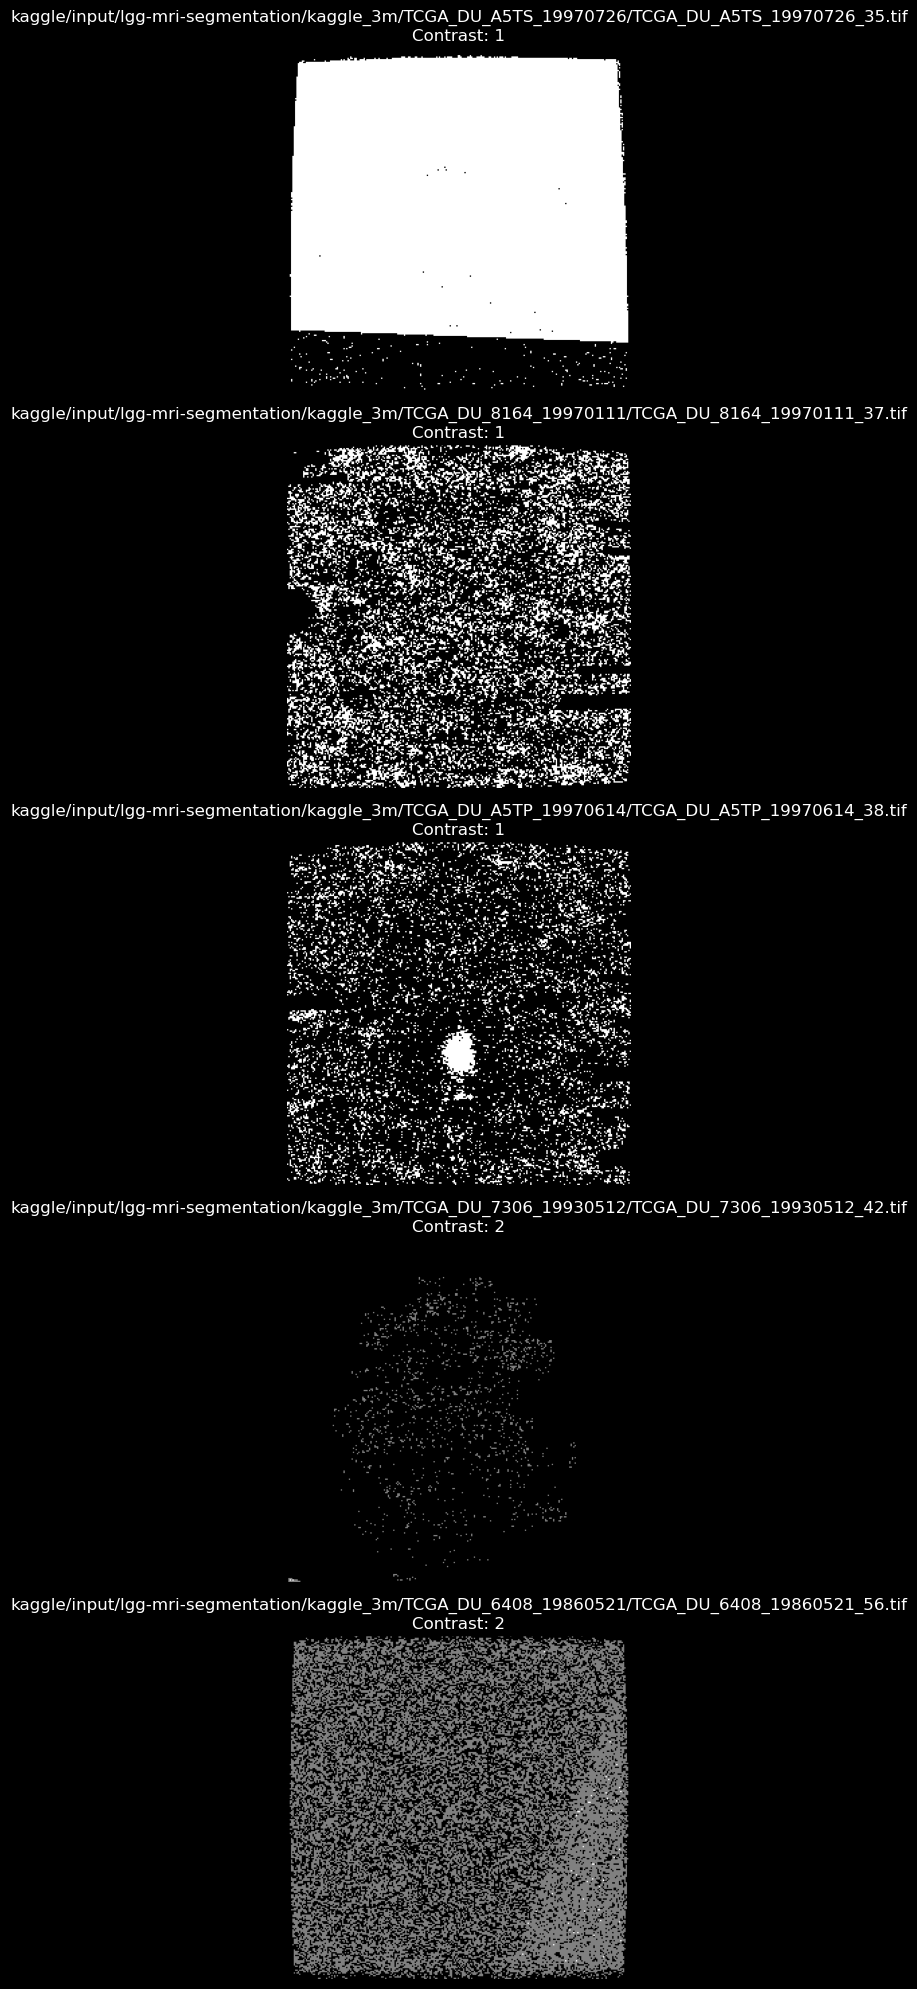

In [20]:
pd.set_option('display.max_colwidth', None)

df['contrast'] = df['image_path'].apply(lambda p: np.ptp(cv2.imread(p, 0)))

low_contrast = df.nsmallest(5, 'contrast')[['image_path', 'contrast']]


print("Top 5 Slices mit niedrigstem Kontrast:")
print(low_contrast)


fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 20))
for ax, (_, row) in zip(axes, low_contrast.iterrows()):
    img = cv2.imread(row['image_path'], 0)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{row['image_path']}\nContrast: {row['contrast']}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [13]:
# Temporal exploration
import re
df['scan_date'] = df['patient'].apply(lambda d: pd.to_datetime(re.search(r'_(\d{8})$', d).group(1), format='%Y%m%d'))
print(df['scan_date'].dt.year.value_counts().sort_index())


scan_date
1983    213
1985    113
1986    281
1989     34
1991    211
1993     99
1994    132
1995    533
1996    203
1997    508
1998    407
1999    168
2000    282
2001    238
2002    338
2003     96
2004     73
Name: count, dtype: int64


In [14]:
# Summary cell
summary = {
  'Total samples': total_samples,
  'Unique patients': unique_patients,
  'Empty (%)': pct_empty,
  'Tumor (%)': pct_pos,
  'Mask frac (mean)': cover.mean(),
}
pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])


,Value
Total samples,3929.000000
Unique patients,110.000000
Empty (%),65.054721
Tumor (%),34.945279
Mask frac (mean),0.007368
